<a href="https://colab.research.google.com/github/aayush9753/LearningResources/blob/master/PyTorch/14_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [4]:
device

device(type='cuda')

In [5]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache

/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [6]:
print(t/10**6)
print(c/10**6)
print(a/10**6)
print(f/10**6)

15812.263936
0.0
0.0
0.0


In [7]:
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [8]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [9]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

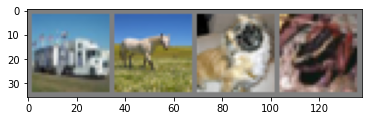

In [11]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size= 5)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels= 16, kernel_size= 5)
    self.fc1 = nn.Linear(in_features=16*5*5,out_features=120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)

  def forward(self,x):
    # -> n . 3 , 32 , 32
    x = self.pool(F.relu(self.conv1(x))) # n , 6, 14 , 14
    x = self.pool(F.relu(self.conv2(x))) # n , 16 , 5 , 5
    x = x.view(-1,16*5*5) # n , 400
    x = F.relu(self.fc1(x))   # n , 120
    x = F.relu(self.fc2(x))   # n , 84
    x = self.fc3(x)   # n , 10
    return x

In [13]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [14]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1831 sha256=19810d71ca964cfd1c52807e98418aa76da8238bd5fb9482e28d94dba54ac79b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [15]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/5], Step [2000/12500], Loss: 2.3170
Epoch [1/5], Step [4000/12500], Loss: 2.2592
Epoch [1/5], Step [6000/12500], Loss: 2.2957
Epoch [1/5], Step [8000/12500], Loss: 2.3452
Epoch [1/5], Step [10000/12500], Loss: 2.0183
Epoch [1/5], Step [12000/12500], Loss: 1.9091
Epoch [2/5], Step [2000/12500], Loss: 1.9990
Epoch [2/5], Step [4000/12500], Loss: 2.3101
Epoch [2/5], Step [6000/12500], Loss: 1.5018
Epoch [2/5], Step [8000/12500], Loss: 2.5495
Epoch [2/5], Step [10000/12500], Loss: 1.8088
Epoch [2/5], Step [12000/12500], Loss: 2.0989
Epoch [3/5], Step [2000/12500], Loss: 2.0691
Epoch [3/5], Step [4000/12500], Loss: 1.9478
Epoch [3/5], Step [6000/12500], Loss: 1.4604
Epoch [3/5], Step [8000/12500], Loss: 1.9400
Epoch [3/5], Step [10000/12500], Loss: 1.9406
Epoch [3/5], Step [12000/12500], Loss: 1.3241
Epoch [4/5], Step [2000/12500], Loss: 1.1782
Epoch [4/5], Step [4000/12500], Loss: 1.4645
Epoch [4/5], Step [6000/12500], Loss: 1.7304
Epoch [4/5], Step [8000/12500], Loss: 1.4824
Epoc

In [16]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 48.2 %
Accuracy of plane: 55.9 %
Accuracy of car: 65.9 %
Accuracy of bird: 35.6 %
Accuracy of cat: 38.7 %
Accuracy of deer: 38.6 %
Accuracy of dog: 39.4 %
Accuracy of frog: 55.0 %
Accuracy of horse: 44.2 %
Accuracy of ship: 56.4 %
Accuracy of truck: 52.3 %
time: 4.75 s


In [17]:
batch_size

4

time: 4.69 ms
